### Convert to Binary Image:
Use image processing software (e.g., ImageJ, Python, MATLAB) to threshold the image and create a binary mask where pores are white (1) and the polymer film is black (0).

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

image_path = '1%A.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image (thresholding to highlight pores)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours of the pores
contours = measure.find_contours(binary_image, 0.8)

# Extract centroids of the pores
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])  # X-coordinate of centroid
        cy = int(M["m01"] / M["m00"])  # Y-coordinate of centroid
        centroids.append((cx, cy))

centroids = np.array(centroids)

[ WARN:0@30.260] global loadsave.cpp:268 findDecoder imread_('1%A.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
print(centroids)

[[   0    9]
 [   0  120]
 [   0 1244]
 [   0   25]
 [   0   63]
 [   0   11]
 [   0   70]
 [   0   68]
 [   0    9]
 [   0  459]
 [   0   12]
 [   0    6]
 [   0   10]
 [   0   10]
 [   0  227]
 [   0   67]
 [   0   81]
 [   0    2]
 [   0   47]
 [   0    5]
 [   0   32]
 [   0   75]
 [   0  461]
 [   0  211]
 [   0   60]
 [   0   17]
 [   0   79]
 [   0   67]
 [   0   21]
 [   0    8]
 [   0  120]
 [   0   61]
 [   0    1]
 [   0   61]
 [   0   58]
 [   0    2]
 [   0   62]
 [   0   10]
 [   0   28]
 [   0  148]
 [   0   64]
 [   0   48]
 [   0   15]
 [   0   57]
 [   0   60]
 [   0   60]
 [   0   79]
 [   0   63]
 [   0   71]
 [   0   15]
 [   0   26]
 [   0  145]
 [   0   17]
 [   0   62]
 [   0   56]
 [   0   63]
 [   0   24]
 [   0   42]
 [   0   68]
 [   0    9]
 [   0   38]
 [   0  123]
 [   0   34]
 [   0   86]
 [   0   20]
 [   0   21]
 [   0   47]
 [   0   40]
 [   0   18]
 [   0   42]
 [   0   38]
 [   0   33]
 [   0   27]
 [   0   28]
 [   0   21]
 [   0   22]
 [   0    6]

 ## Extract Droplet Centroids

In [1]:
import cv2

# Load image
image = cv2.imread('0.3%A.png')

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Apply histogram equalization
equalized_image = cv2.equalizeHist(gray_image)
# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
adaptive_equalized_image = clahe.apply(gray_image)
# Apply Otsu’s thresholding
ret, thresholded_image = cv2.threshold(equalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Apply Canny edge detection
edges = cv2.Canny(equalized_image, threshold1=100, threshold2=200)
# Define kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Apply morphological opening (removes small noise)
opened_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel)

# Apply morphological closing (fills small holes)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)
# Set up SimpleBlobDetector
params = cv2.SimpleBlobDetector_Params()

# Adjust the parameters (e.g., area, circularity, convexity, inertia)
params.filterByArea = True
params.minArea = 100
params.filterByCircularity = True
params.minCircularity = 0.5
params.filterByConvexity = True
params.minConvexity = 0.5
params.filterByInertia = True
params.minInertiaRatio = 0.5

# Create a blob detector with the given parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs (droplets)
keypoints = detector.detect(closed_image)

# Draw keypoints on the image to visualize the detected centroids
output_image = cv2.drawKeypoints(closed_image, keypoints, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
centroids = [kp.pt for kp in keypoints]
print("Droplet centroids:", centroids)



NameError: name 'np' is not defined

[[144 110]
 [100 108]
 [112 108]
 [124 105]
 [152 101]
 [ 82 106]
 [136 100]
 [125  95]
 [ 98  95]
 [ 67  96]
 [157  94]
 [ 34 102]
 [134  85]
 [153  78]
 [123  75]
 [112  69]
 [  0  60]
 [140  61]
 [155  52]
 [ 17  52]
 [143  48]
 [ 55  70]
 [ 48  50]
 [112  50]
 [ 31  47]
 [ 86  41]
 [ 70  40]
 [129  42]
 [103  36]
 [  8  42]
 [ 50  37]
 [153  35]
 [ 29  31]
 [  4  27]
 [131  25]
 [ 85  27]
 [143  21]
 [ 48  23]
 [155  19]
 [  6  13]
 [ 23  17]
 [ 68  12]
 [ 42  10]
 [ 82  11]
 [133  10]
 [ 95   8]
 [146   6]
 [108   5]
 [157   3]
 [ 74   1]
 [ 49   1]
 [ 32   1]
 [ 16   4]
 [  0   1]]


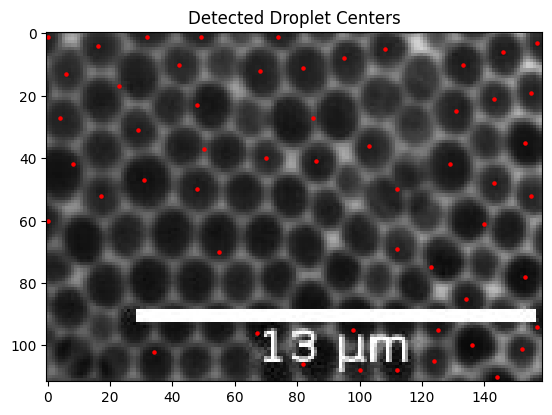

In [9]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('0.3%B.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Contrast Enhancement (Histogram Equalization)
equalized_image = cv2.equalizeHist(image)

# Step 2: Apply Manual Thresholding (with dynamic range)
# Experiment with threshold values based on your image contrast
_, thresh = cv2.threshold(equalized_image, 100, 255, cv2.THRESH_BINARY_INV)

# Step 3: Apply Morphological Operations (Opening followed by Closing)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # More elliptical kernel for smoother operation
opened_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)

# Step 4: Find Contours instead of using Blob Detector
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Identify Droplet Centroids using Contour Moments
centroids = []
for contour in contours:
    # Calculate the centroid of each contour using moments
    M = cv2.moments(contour)
    if M["m00"] != 0:  # Prevent division by zero
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append([cx, cy])
# centroids.append([267,98])
# Convert centroids to a numpy array for easier plotting
centroids = np.array(centroids)
print(centroids)

# Plot Results
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')
plt.show()


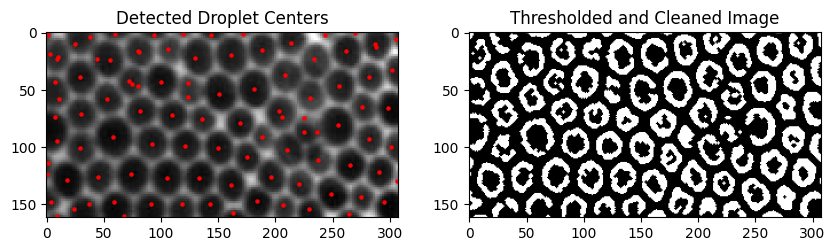

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('0.3%.png', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Apply Gaussian Blur to Reduce Noise
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Apply Adaptive Thresholding
# This handles uneven lighting better than Otsu or fixed thresholding
thresh = cv2.adaptiveThreshold(
    blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Step 3: Apply Morphological Operations (Optional)
# Use only if necessary to clean up the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  # Small kernel for fine details
cleaned_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)  # Remove small noise
cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_CLOSE, kernel)  # Fill small holes

# Step 4: Find Contours
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Identify Droplet Centroids using Contour Moments
centroids = []
for contour in contours:
    # Calculate the centroid of each contour using moments
    M = cv2.moments(contour)
    if M["m00"] != 0:  # Prevent division by zero
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append([cx, cy])

# Convert centroids to a numpy array for easier plotting
centroids = np.array(centroids)

# Step 6: Plot Results
plt.figure(figsize=(10, 5))

# Original Image with Detected Centroids
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=5)
plt.title('Detected Droplet Centers')

# Thresholded Image for Debugging
plt.subplot(1, 2, 2)
plt.imshow(cleaned_image, cmap='gray')
plt.title('Thresholded and Cleaned Image')

plt.show()

## Perform Voronoi Tessellation

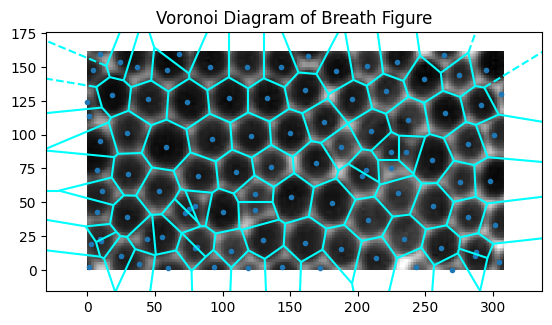

In [13]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Compute Voronoi Tessellation
vor = Voronoi(centroids)

# Plot Voronoi Diagram
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='cyan', line_width=1.5)
plt.title('Voronoi Diagram of Breath Figure')
plt.show()


## Analyze Voronoi Cell Shapes

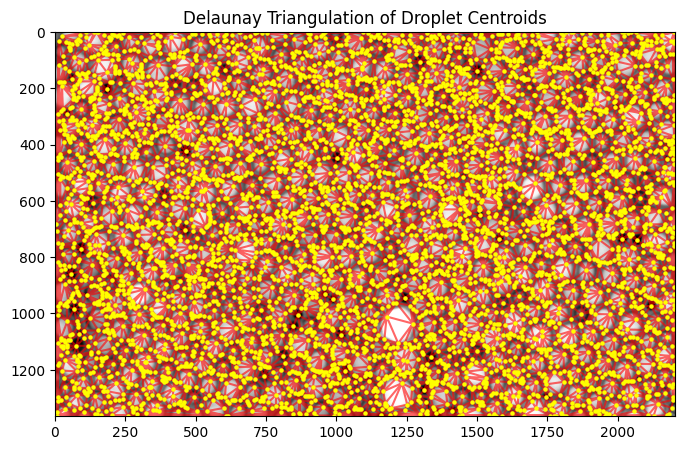

In [5]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Load SEM Image
# Preprocess Image (assuming previous steps are done and centroids are detected)
# This part assumes that centroids are already identified, e.g., using contours or other method

# Example centroid array (replace with actual centroids)
# centroids = np.array([[100, 150], [200, 250], [300, 350], ...])

# Compute Delaunay Triangulation (corrected to use centroids as (x, y))
tri = Delaunay(centroids)

# Plotting the Image with Delaunay Triangulation
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.triplot(centroids[:, 0], centroids[:, 1], tri.simplices, color='red', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', s=5)
plt.title('Delaunay Triangulation of Droplet Centroids')
plt.show()


## Quantitative Metrics

Hexagonality Ratio: 0.38


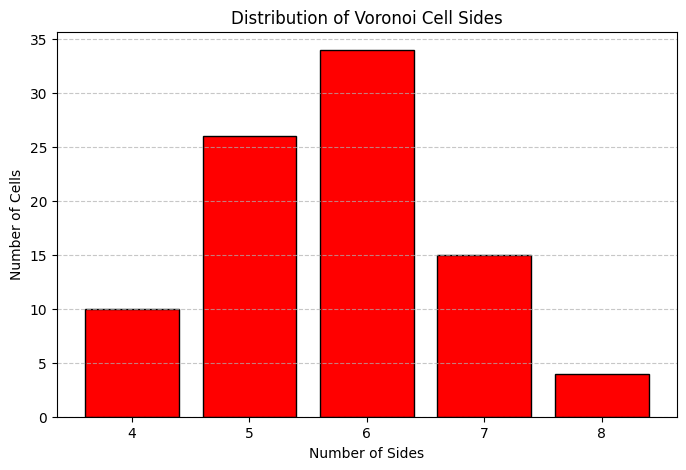

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Construct Graph from Voronoi
graph = nx.Graph()
for i, region in enumerate(vor.regions):
    if -1 in region or len(region) == 0:
        continue
    graph.add_node(i, sides=len(region))

# Extract Number of Hexagonal Cells
hexagonal_cells = [n for n, attr in graph.nodes(data=True) if attr['sides'] == 6]
hexagonality_ratio = len(hexagonal_cells) / len(graph.nodes)

print(f'Hexagonality Ratio: {hexagonality_ratio:.2f}')

# Count the number of cells for each number of sides
side_counts = {}
for n, attr in graph.nodes(data=True):
    sides = attr['sides']
    if sides in side_counts:
        side_counts[sides] += 1
    else:
        side_counts[sides] = 1

# Sort the sides for better visualization
sorted_sides = sorted(side_counts.keys())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_sides, [side_counts[s] for s in sorted_sides], color='red', edgecolor='black')
plt.xlabel('Number of Sides')
plt.ylabel('Number of Cells')
plt.title('Distribution of Voronoi Cell Sides')
plt.xticks(sorted_sides)  # Ensure all side numbers are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

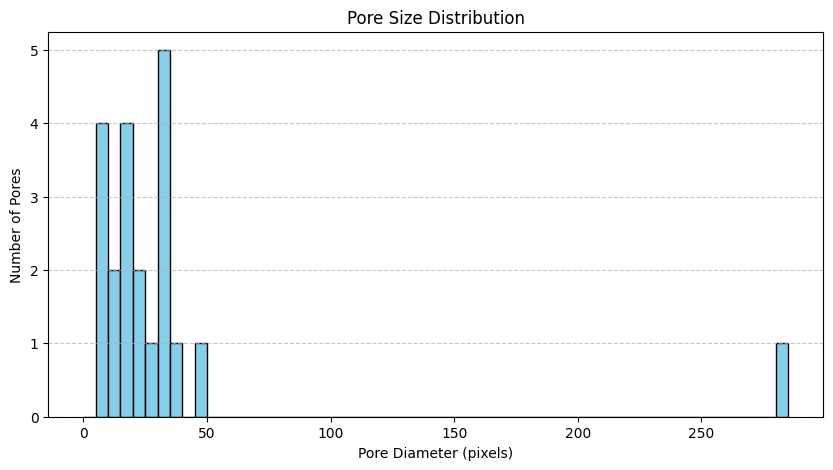

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load SEM Image in Grayscale
image = cv2.imread('0.3%A.png', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Step 1: Preprocess the Image (Thresholding and Cleaning)
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Step 2: Find Contours of Pores
contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate Pore Diameters
pore_diameters = []
for contour in contours:
    area = cv2.contourArea(contour)
    equivalent_diameter = 2 * np.sqrt(area / np.pi)  # Diameter of a circle with the same area
    pore_diameters.append(equivalent_diameter)

# Step 4: Bin the Pore Diameters for the Bar Chart
# Define bin edges (adjust based on your pore size range)
bin_edges = np.arange(0, max(pore_diameters) + 5, 5)  # Bins of 5 units (e.g., pixels)
hist, bin_edges = np.histogram(pore_diameters, bins=bin_edges)

# Step 5: Plot the Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], hist, width=5, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('Pore Diameter (pixels)')
plt.ylabel('Number of Pores')
plt.title('Pore Size Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()